# Diagramming


Several diagramming notations have been used for designing relational schema, as already introduced in the section on [Relational Theory](../20-concepts/01-relational.md).

DataJoint comes with a powerful diagramming notation that becomes useful for both data modeling and for exploring an existing schema.

A DataJoint schema is depicted as a Directed Acyclic Graph (DAG), where nodes are tables and edges represent the foreign key constraints between them.

Let's start with a simple schema called "projects" depicting employees, projects, and assignments of projects to employees, a many-to-many relationship.




In [2]:
import datajoint as dj

dj.conn()


schema = dj.Schema("projects")

@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int
    ---
    employee_name : varchar(60)
    """

@schema
class Project(dj.Manual):
    definition = """
    project_code  : varchar(8)
    ---
    project_title : varchar(50)
    start_date : date
    end_date : date
    """
    
@schema
class Assignment(dj.Manual):
    definition = """
    -> Employee
    -> Project
    ---
    percent_effort : decimal(4,1) unsigned
    """

[2025-09-18 14:51:23,804][INFO]: DataJoint 0.14.6 connected to dev@db:3306


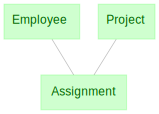

In [4]:
dj.Diagram(schema)